In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="179"

In [2]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [3]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


ModuleNotFoundError: No module named 'sql'

In [4]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_prod_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

NameError: name 'con' is not defined

In [5]:
original_df.info()

NameError: name 'original_df' is not defined

In [6]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [7]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
300619  2018-03-05T05:18:25Z         179    BNE         YVR             36   
300620  2018-02-27T02:49:46Z         179    RSW         YYZ           1237   
300621  2018-02-25T14:57:39Z         179    YYZ         CUN           1810   
300622  2017-12-22T04:14:43Z         179    PHX         YVR           1841   
300623  2017-11-06T19:20:20Z         179    DEN         YYZ           1038   

       departure_date departure_time currency language  pax   ...    \
300619     2018-04-02          10:40      CAD       en    2   ...     
300620     2018-03-17          13:40      CAD       en    2   ...     
300621     2018-03-06          06:15      CAD       en    2   ...     
300622     2018-01-01          14:15      CAD       en    1   ...     
300623     2017-11-12          10:30      USD       en    1   ...     

        upgrade_type duration distance equipment slider_max_usd  \
300619      BUSINESS      810     7372       788         1448.0   
300620      BUSINESS      175     1192       321          492.0   
300621      BUSINESS      245     1621       763          490.0   
300622      BUSINESS      190     1232       763          471.0   
300623      BUSINESS      178     1313       E90          485.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
300619          809.0            986.0     1281.1802    4232406.0    True  
300620          196.0            257.0      215.3140    4211093.0    True  
300621          198.0            257.0      237.1798    4205304.0    True  
300622          196.0            275.0      235.6730    3987245.0    True  
300623          215.0            293.0      220.0000    3830631.0    True  

[5 rows x 26 columns]

In [8]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    300624.0  300624.000000  300624.000000  300624.000000  300624.000000   
mean        179.0    1129.326055       1.522137     379.725913    2979.890275   
std           0.0    1869.385652       0.840552     238.198877    2136.344043   
min         179.0       1.000000       1.000000      40.000000      89.000000   
25%         179.0     118.000000       1.000000     190.000000    1260.000000   
50%         179.0     710.000000       1.000000     305.000000    2237.000000   
75%         179.0    1118.000000       2.000000     535.000000    4364.000000   
max         179.0    8987.000000       9.000000    1237.000000    9676.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   300624.000000   300624.000000     300624.000000   60125.00000   
mean       815.081061      380.926905        504.866434     435.36431   
std        447.559532      270.518497        320.524980     296.87014   
min        190.000000       59.000000         95.000000      61.18650   
25%        483.000000      178.000000        261.000000     222.51730   
50%        656.000000      282.000000        402.000000     320.91950   
75%       1003.000000      547.000000        682.000000     600.00000   
max       2548.000000     1849.000000       2202.000000    2506.25750   

        customer_id  
count  6.012500e+04  
mean   3.877800e+06  
std    2.973369e+05  
min    2.888761e+06  
25%    3.716850e+06  
50%    3.906585e+06  
75%    4.110184e+06  
max    4.315971e+06

In [9]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 300624  300624      300624         300624   
unique                236425     142         142            524   
top     2018-02-21T19:06:50Z     YYZ         YYZ     2018-03-29   
freq                       9   86954       91783           2004   

       departure_time currency language point_of_sale    channel_source  \
count          300624   300624   300624        300624            300624   
unique            248       12        8            68                18   
top             08:00      CAD       en            CA  PRE_TRAVEL_EMAIL   
freq             6116   246198   289269        240941            145995   

       carrier_code fare_class from_cabin upgrade_type equipment  
count        300624     300624     300624       300624    300624  
unique            1         19          2            2        19  
top              AC          K    ECONOMY     BUSINESS       77W  
freq         300624      94001     282910       233299     56235

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283459 entries, 0 to 283458
Data columns (total 26 columns):
event_time          283459 non-null object
partner_id          283459 non-null int64
origin              283459 non-null object
destination         283459 non-null object
flight_number       283459 non-null int64
departure_date      283459 non-null object
departure_time      283459 non-null object
currency            283459 non-null object
language            283459 non-null object
pax                 283459 non-null int64
eligibility         283459 non-null bool
point_of_sale       283459 non-null object
channel_source      283459 non-null object
carrier_code        283459 non-null object
fare_class          283459 non-null object
from_cabin          283459 non-null object
upgrade_type        283459 non-null object
duration            283459 non-null int64
distance            283459 non-null int64
equipment           283459 non-null object
slider_max_usd      283459 non-null 

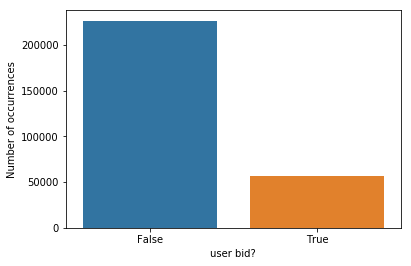

Has_bid percentage: 25.00%


In [11]:
#What is the distribution of has bid
sns.countplot(df.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = df["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


## Conclusions about the original data

* missing data and unbalanced dataset


## Numerical analysis

## Visualization analysis

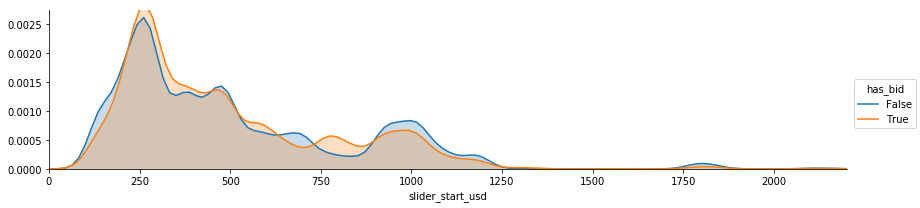

In [12]:
plot_distribution( df , var = 'slider_start_usd' , target = 'has_bid' )

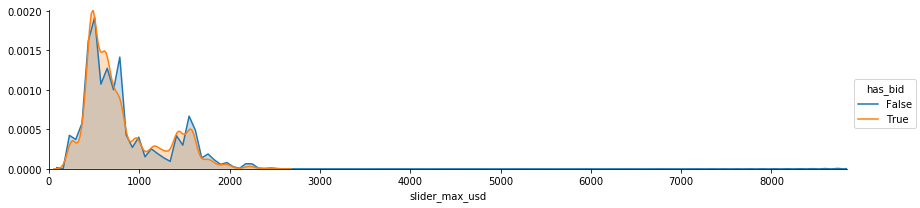

In [13]:
plot_distribution( df , var = 'slider_max_usd' , target = 'has_bid' )

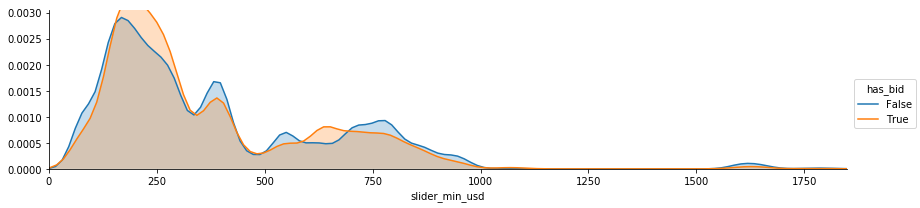

In [14]:
plot_distribution( df , var = 'slider_min_usd' , target = 'has_bid' )

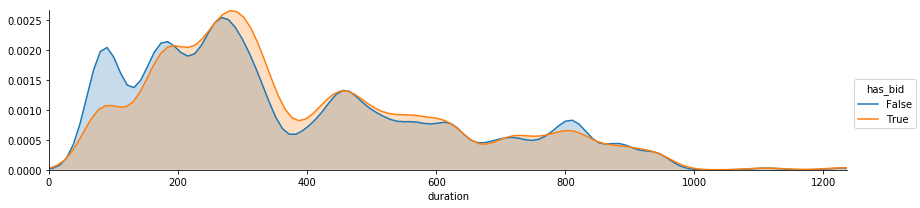

In [15]:
plot_distribution( df , var = 'duration' , target = 'has_bid' )

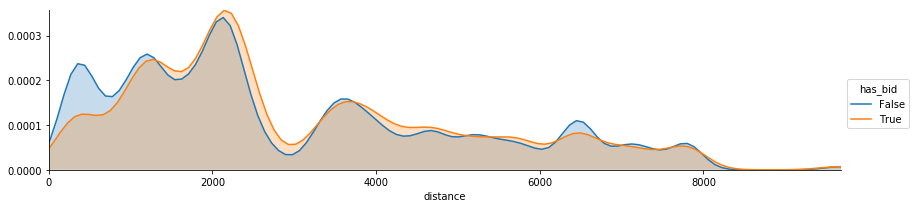

In [16]:
plot_distribution( df , var = 'distance' , target = 'has_bid' )

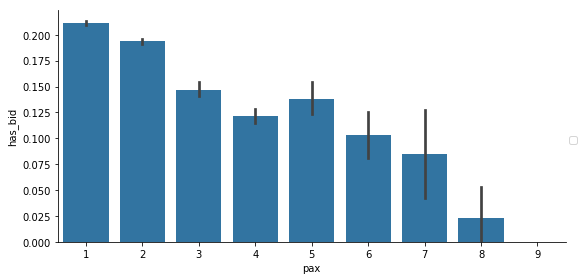

In [17]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

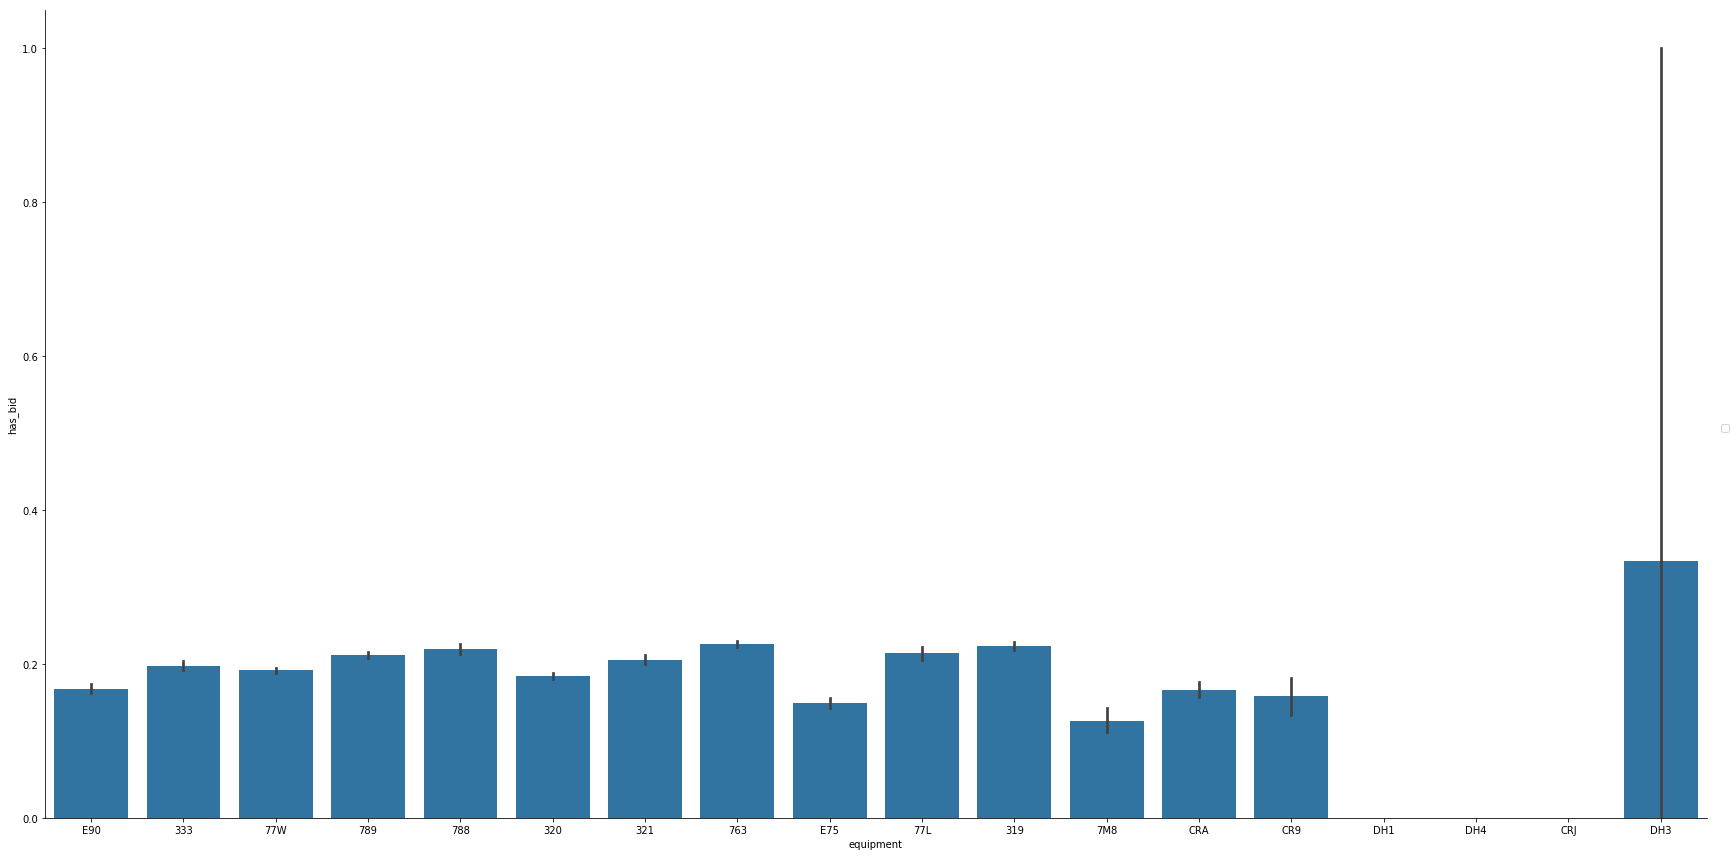

In [18]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

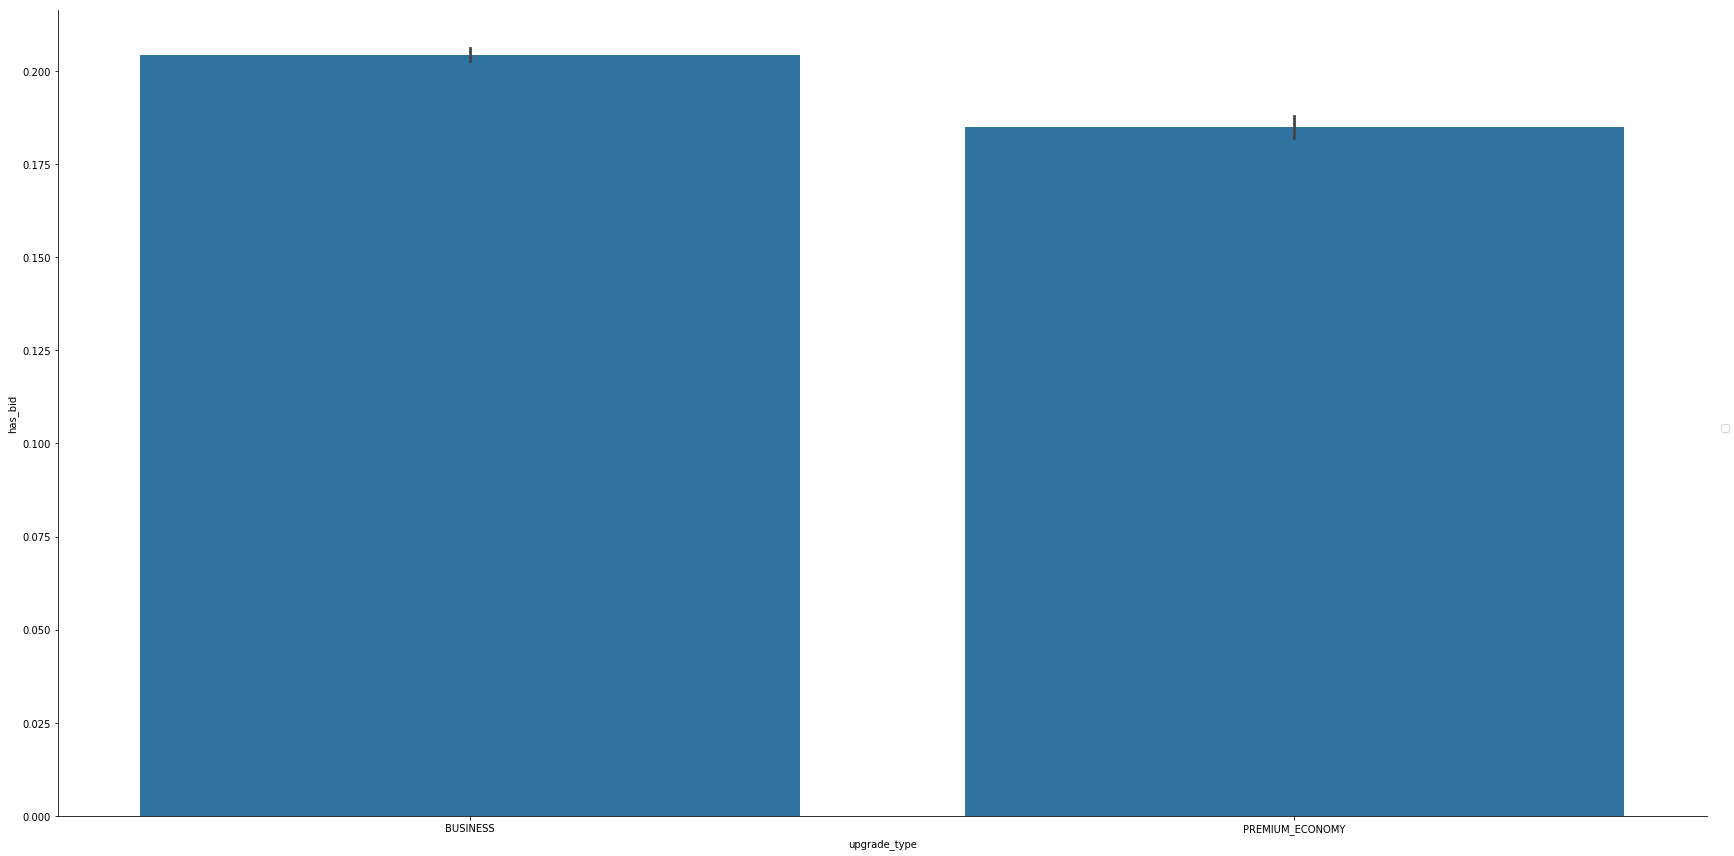

In [19]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

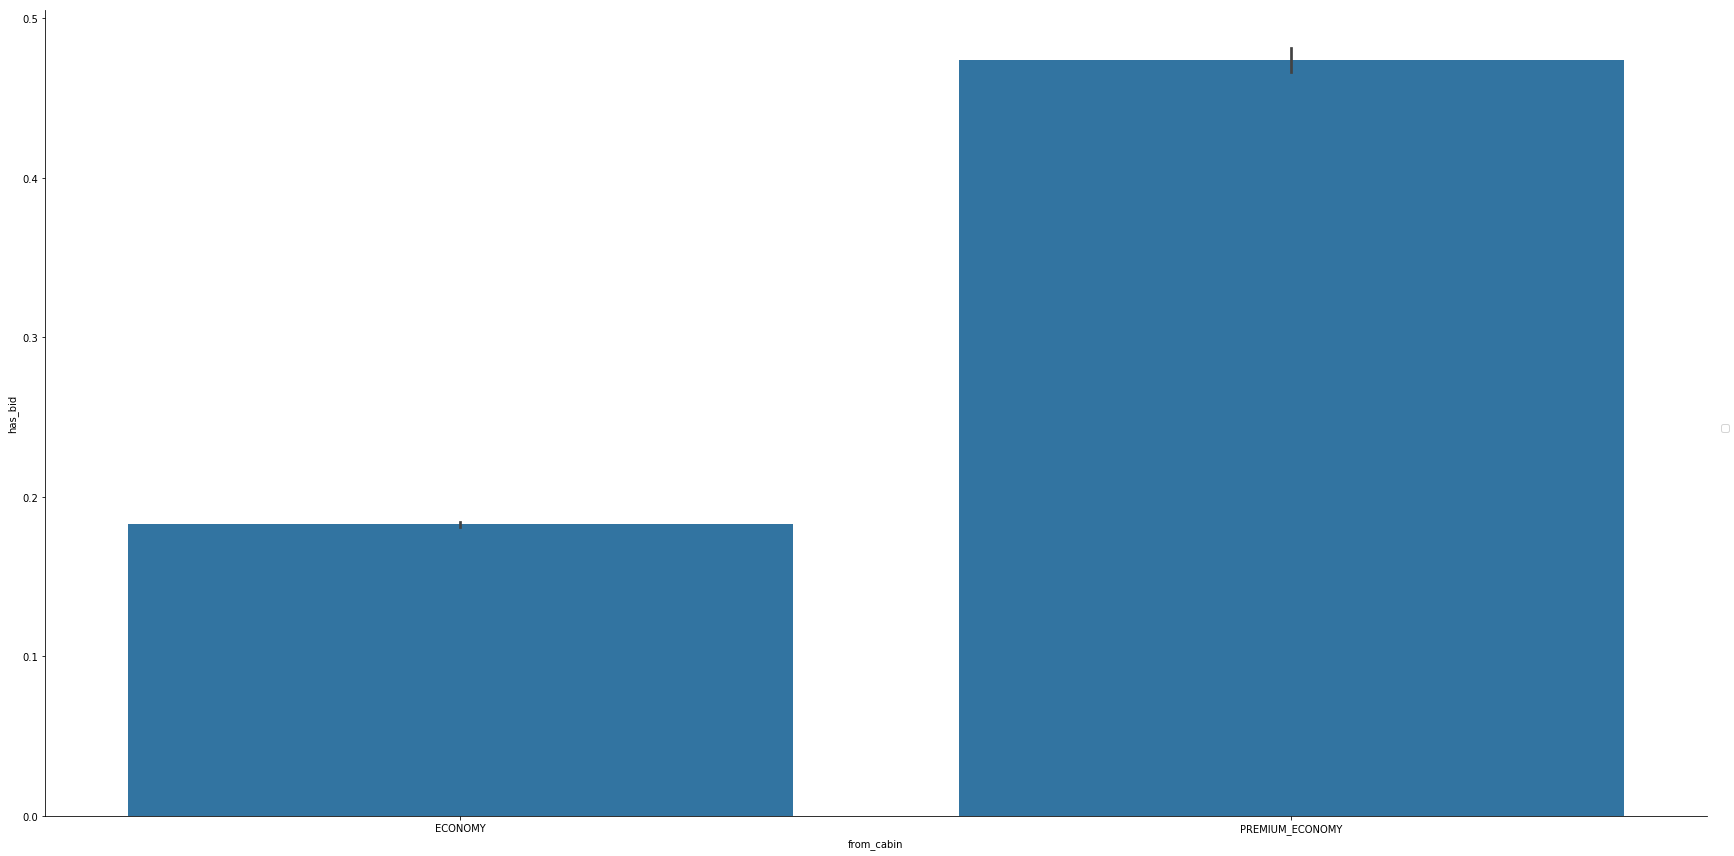

In [20]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

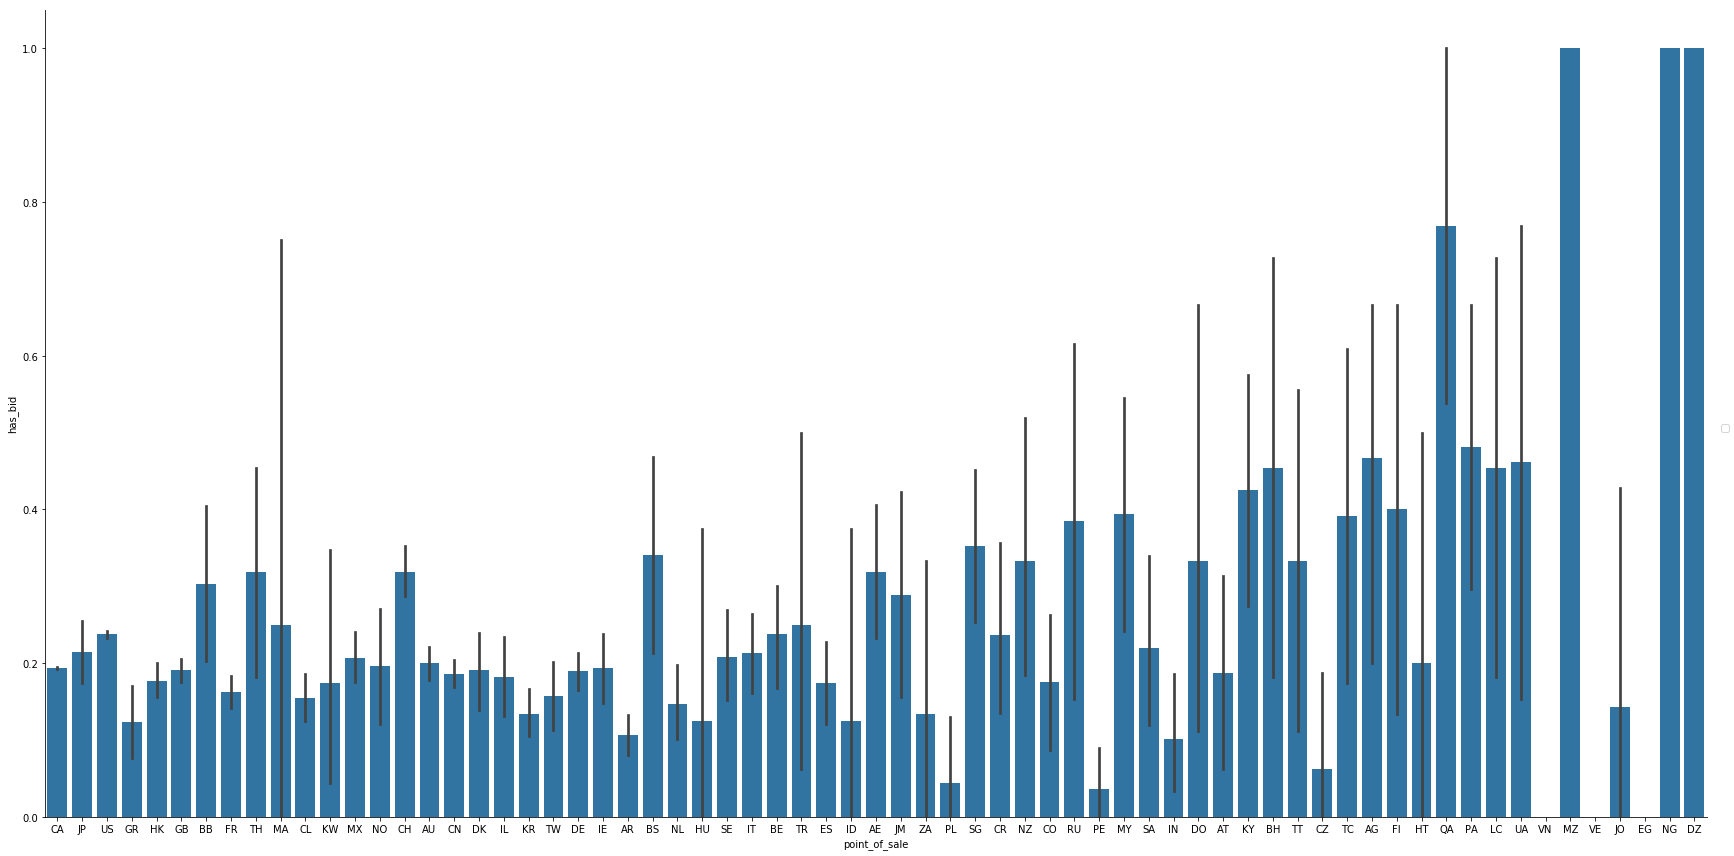

In [21]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

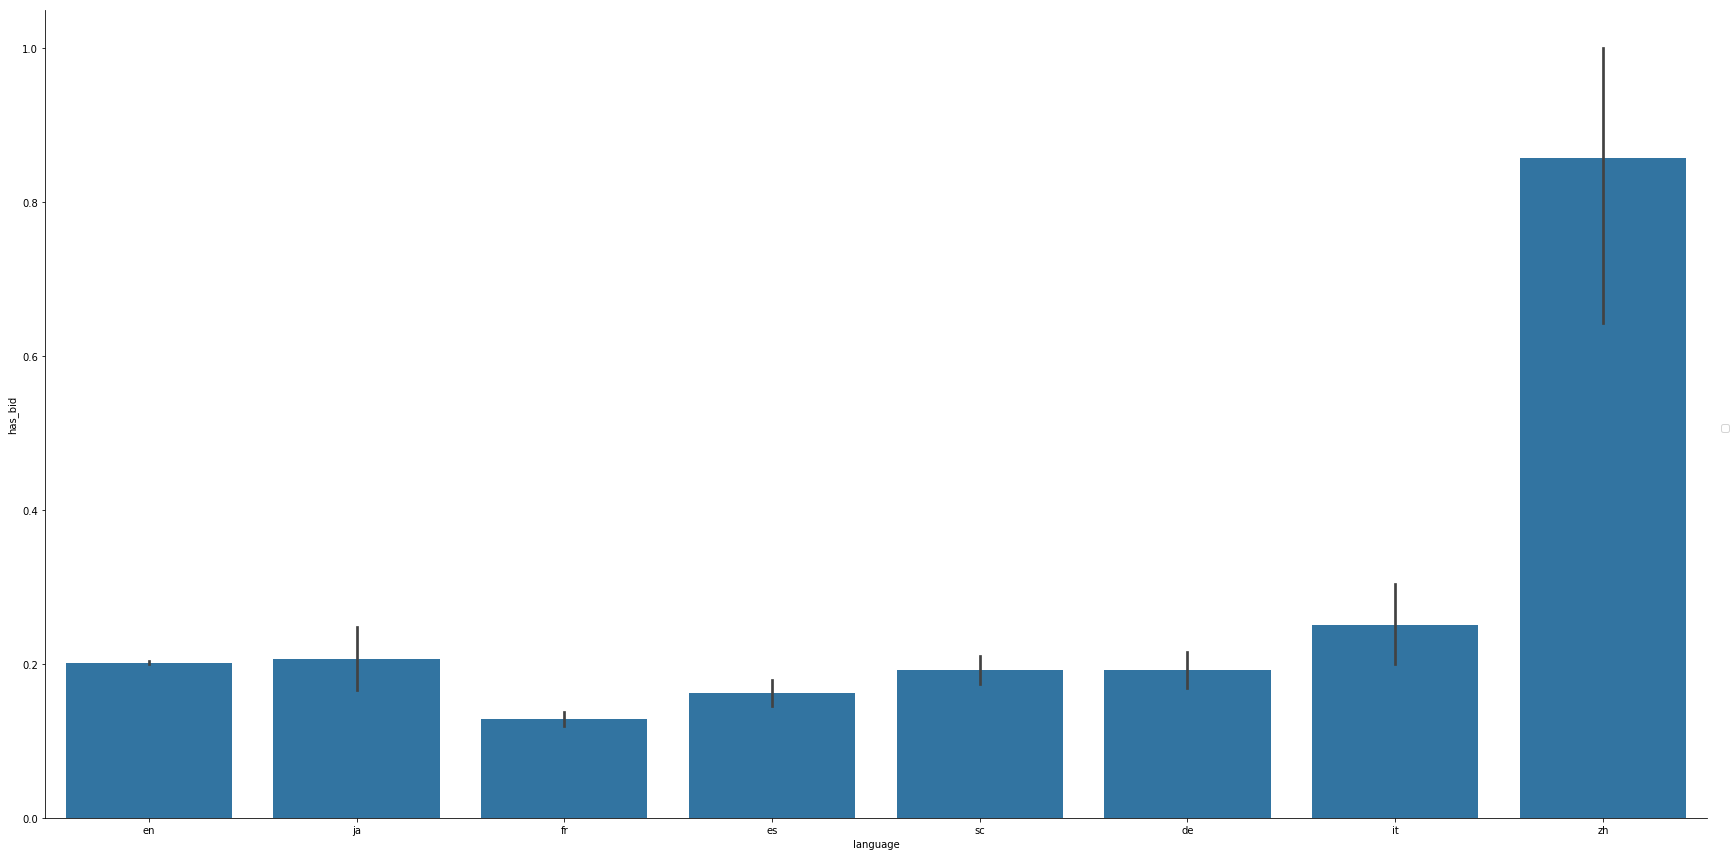

In [22]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [23]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(0)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)

train_df = df_nonNas.copy()


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283459 entries, 0 to 283458
Data columns (total 26 columns):
event_time          283459 non-null object
partner_id          283459 non-null int64
origin              283459 non-null object
destination         283459 non-null object
flight_number       283459 non-null float32
departure_date      283459 non-null object
departure_time      283459 non-null object
currency            283459 non-null object
language            283459 non-null object
pax                 283459 non-null float32
eligibility         283459 non-null bool
point_of_sale       283459 non-null object
channel_source      283459 non-null object
carrier_code        283459 non-null object
fare_class          283459 non-null object
from_cabin          283459 non-null object
upgrade_type        283459 non-null object
duration            283459 non-null float32
distance            283459 non-null float32
equipment           283459 non-null object
slider_max_usd      283459 n

### Prepare dataset

In [25]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
leOrigin = preprocessing.LabelEncoder()
leDestination = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    leDestination.fit(train_df_fact["destination"])
    train_df_fact["destination"] = leDestination.transform(train_df_fact["destination"])
    leOrigin.fit(train_df_fact["origin"])
    train_df_fact["origin"] = leOrigin.transform(train_df_fact["origin"])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [26]:
#factorize the categorical fields
columns_cat = ["equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]  
train_df_fact = factorize_df(train_df, columns_cat) 

In [27]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283459 entries, 0 to 283458
Data columns (total 26 columns):
event_time          283459 non-null object
partner_id          283459 non-null int64
origin              283459 non-null int64
destination         283459 non-null int64
flight_number       283459 non-null int64
departure_date      283459 non-null object
departure_time      283459 non-null int64
currency            283459 non-null int64
language            283459 non-null int64
pax                 283459 non-null float32
eligibility         283459 non-null bool
point_of_sale       283459 non-null int64
channel_source      283459 non-null int64
carrier_code        283459 non-null int64
fare_class          283459 non-null int64
from_cabin          283459 non-null int64
upgrade_type        283459 non-null int64
duration            283459 non-null float32
distance            283459 non-null float32
equipment           283459 non-null int64
slider_max_usd      283459 non-null float3

## Create a model and evaluation

In [28]:
#Function utils
from sklearn.linear_model import LogisticRegression

random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 

    return add_noise(ft_trn_series, noise_level)


In [29]:
origins = train_df_fact.origin.unique()
destinations = train_df_fact.destination.unique()

def getTestDatasetsByRoute(testDatasetsX, testDatasetsY):
    datasetsByRouteX = []
    datasetsByRouteY = []
    origins_labels = []
    destinations_labels = []
    for i in origins:
        for j in destinations:
            idx = (testDatasetsX['origin'] == i) & (testDatasetsX['destination'] == j)
            datasetsByRouteX.append(testDatasetsX.loc[idx].copy())
            datasetsByRouteY.append(testDatasetsY.loc[idx].copy())
            origins_labels.append(i)
            destinations_labels.append(j)
    return datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels
    

def do_train_and_validate_by_route(df_to_train, n_splits = 2):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    X_train, X_valid, y_train, y_valid = train_test_split(x,y, test_size=0.30, random_state=42)
    random_forest.fit(X_train, y_train)
    datasetsByRouteX, datasetsByRouteY, origins_labels, destinations_labels = getTestDatasetsByRoute(X_valid, y_valid)
    results = []
    for idx, val in enumerate(datasetsByRouteX):
        if (datasetsByRouteX[idx].shape[0] > 500):
            Y_test_pred = random_forest.predict_proba(datasetsByRouteX[idx])[:,1]
            fpr, tpr, _ = metrics.roc_curve(datasetsByRouteY[idx].astype(int), Y_test_pred)
            results.append([metrics.auc(fpr, tpr), leOrigin.inverse_transform(origins_labels[idx]), leDestination.inverse_transform(destinations_labels[idx])])
    results.sort(key=lambda x: x[0], reverse = True)
    for result in results:
        print("AUC = {}, ORIGIN = {}, DESTINATION = {}".format(result[0], result[1], result[2]))



### Feature engineering

In [30]:
#add days before departure and destination_origin
train_df2 = train_df.copy()
train_df2_020 = train_df2.copy()

train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df_fact2 = factorize_df(train_df2_020, columns_cat2) 


In [31]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283459 entries, 0 to 283458
Data columns (total 28 columns):
event_time               283459 non-null object
partner_id               283459 non-null int64
origin                   283459 non-null int64
destination              283459 non-null int64
flight_number            283459 non-null int64
departure_date           283459 non-null object
departure_time           283459 non-null int64
currency                 283459 non-null int64
language                 283459 non-null int64
pax                      283459 non-null float32
eligibility              283459 non-null bool
point_of_sale            283459 non-null int64
channel_source           283459 non-null int64
carrier_code             283459 non-null int64
fare_class               283459 non-null int64
from_cabin               283459 non-null int64
upgrade_type             283459 non-null int64
duration                 283459 non-null float32
distance                 283459 non-nu

In [32]:
train_df_3 = train_df_fact2.drop(["partner_id","eligibility", "departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "customer_id", "offer_amount"], axis=1)

In [ ]:
train_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283459 entries, 0 to 283458
Data columns (total 18 columns):
origin                   283459 non-null int64
destination              283459 non-null int64
flight_number            283459 non-null int64
departure_time           283459 non-null int64
currency                 283459 non-null int64
pax                      283459 non-null float32
channel_source           283459 non-null int64
carrier_code             283459 non-null int64
fare_class               283459 non-null int64
duration                 283459 non-null float32
distance                 283459 non-null float32
equipment                283459 non-null int64
slider_max_usd           283459 non-null float32
slider_min_usd           283459 non-null float32
slider_start_usd         283459 non-null float32
has_bid                  283459 non-null bool
days_before_departure    283459 non-null int64
destination_origin       283459 non-null int64
dtypes: bool(1), float32(6), int

In [ ]:
do_train_and_validate_by_route(train_df_3)